In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import caffe
import os
import tempfile
import matplotlib.pyplot as plt

CAFFE_ROOT = '/home/albert/caffe/'
sys.path.insert(0, CAFFE_ROOT + 'python')

%matplotlib inline

In [2]:
# Helper function for deprocessing preprocessed images, e.g., for display.
def deprocess_net_image(image):
    image = image.copy()              # don't modify destructively
    image = image[::-1]               # BGR -> RGB
    image = image.transpose(1, 2, 0)  # CHW -> HWC

    # clamp values in [0, 255]
    image[image < 0], image[image > 255] = 0, 255

    # round and cast from float32 to uint8
    image = np.round(image)
    image = np.require(image, dtype=np.uint8)

    return image

In [3]:
ref_weights = os.path.join(CAFFE_ROOT, 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel')
assert os.path.exists(ref_weights)
print(ref_weights)

/home/albert/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel


In [4]:
market_labels = np.array(list(np.loadtxt(CAFFE_ROOT + 'data/market-1501/labels.txt', 
                                str, delimiter='\n'))).astype(np.uint16).tolist()

In [5]:
from caffe import layers as L
from caffe import params as P

weight_param = dict(lr_mult=1, decay_mult=1)
bias_param   = dict(lr_mult=2, decay_mult=0)
learned_param = [weight_param, bias_param]

frozen_param = [dict(lr_mult=0)] * 2

In [6]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1,
              param=learned_param,
              weight_filler=dict(type='gaussian', std=0.01),
              bias_filler=dict(type='constant', value=0.1)):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                         num_output=nout, pad=pad, group=group,
                         param=param, weight_filler=weight_filler,
                         bias_filler=bias_filler)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout, param=learned_param,
            weight_filler=dict(type='gaussian', std=0.005),
            bias_filler=dict(type='constant', value=0.1)):
    fc = L.InnerProduct(bottom, num_output=nout, param=param,
                        weight_filler=weight_filler,
                        bias_filler=bias_filler)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def caffenet(data, label=None, train=True, num_classes=1000,
             classifier_name='fc8', learn_all=False):
    """Returns a NetSpec specifying CaffeNet, following the original proto text
       specification (./models/bvlc_reference_caffenet/train_val.prototxt)."""
    n = caffe.NetSpec()
    n.data = data
    param = learned_param if learn_all else frozen_param
    n.conv1, n.relu1 = conv_relu(n.data, 11, 96, stride=4, param=param)
    n.pool1 = max_pool(n.relu1, 3, stride=2)
    n.norm1 = L.LRN(n.pool1, local_size=5, alpha=1e-4, beta=0.75)
    n.conv2, n.relu2 = conv_relu(n.norm1, 5, 256, pad=2, group=2, param=param)
    n.pool2 = max_pool(n.relu2, 3, stride=2)
    n.norm2 = L.LRN(n.pool2, local_size=5, alpha=1e-4, beta=0.75)
    n.conv3, n.relu3 = conv_relu(n.norm2, 3, 384, pad=1, param=param)
    n.conv4, n.relu4 = conv_relu(n.relu3, 3, 384, pad=1, group=2, param=param)
    n.conv5, n.relu5 = conv_relu(n.relu4, 3, 256, pad=1, group=2, param=param)
    n.pool5 = max_pool(n.relu5, 3, stride=2)
    n.fc6_market, n.relu6 = fc_relu(n.pool5, 4096, param=param)
    if train:
        n.drop6 = fc7input = L.Dropout(n.relu6, in_place=True)
    else:
        fc7input = n.relu6
    n.fc7, n.relu7 = fc_relu(fc7input, 4096, param=param)
    if train:
        n.drop7 = fc8input = L.Dropout(n.relu7, in_place=True)
    else:
        fc8input = n.relu7
    # always learn fc8 (param=learned_param)
    fc8 = L.InnerProduct(fc8input, num_output=num_classes, param=learned_param)
    # give fc8 the name specified by argument `classifier_name`
    n.__setattr__(classifier_name, fc8)
    if not train:
        n.probs = L.Softmax(fc8)
    if label is not None:
        n.label = label
        n.loss = L.SoftmaxWithLoss(fc8, n.label)
        n.acc = L.Accuracy(fc8, n.label)
    
    # write the net to a temporary file and return its filename
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(n.to_proto()))
        return f.name, n.to_proto()

In [7]:
dummy_data = L.DummyData(shape=dict(dim=[1, 3, 227, 227]))
imagenet_net_filename, imagenet_proto = caffenet(data=dummy_data, train=False)
imagenet_net = caffe.Net(imagenet_net_filename, ref_weights, caffe.TEST)

In [35]:
print(imagenet_proto)

layer {
  name: "data"
  type: "DummyData"
  top: "data"
  dummy_data_param {
    shape {
      dim: 1
      dim: 3
      dim: 227
      dim: 227
    }
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0.0
  }
  param {
    lr_mult: 0.0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.00999999977648
    }
    bias_filler {
      type: "constant"
      value: 0.10000000149
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "pool1"
  top: "norm1"
  lrn_param {
    local_size: 5
    alpha: 9.99999974738e-05
    beta: 0.75
  }
}
layer {
  name: "conv2"
  type: "Convolution"
  bottom: "norm1"
  top: "c

In [9]:
imagenet_net.forward()
print(imagenet_net.blobs['fc6_market'].data.shape)

(1, 4096)


In [10]:
def market_net(train=True, learn_all=False, subset=None):
    if subset is None:
        subset = 'train' if train else 'test'
    source = CAFFE_ROOT + 'data/market-1501/%s.txt' % subset
    transform_param = dict(mirror=train, 
#                            crop_size=227,
#         mean_file=CAFFE_ROOT + 'data/ilsvrc12/imagenet_mean.binaryproto'
                          )
    market_data, market_label = L.ImageData(
        transform_param=transform_param, source=source,
        batch_size=50, new_height=128, new_width=64, ntop=2)
    return caffenet(data=market_data, label=market_label, train=train,
                    num_classes=751,
                    classifier_name='fc8_market',
                    learn_all=False)

In [11]:
market_net_filename, market_net_proto = market_net(train=False, subset='train')
print(market_net_proto)

layer {
  name: "data"
  type: "ImageData"
  top: "data"
  top: "label"
  transform_param {
    mirror: false
  }
  image_data_param {
    source: "/home/albert/caffe/data/market-1501/train.txt"
    batch_size: 50
    new_height: 128
    new_width: 64
  }
}
layer {
  name: "conv1"
  type: "Convolution"
  bottom: "data"
  top: "conv1"
  param {
    lr_mult: 0.0
  }
  param {
    lr_mult: 0.0
  }
  convolution_param {
    num_output: 96
    pad: 0
    kernel_size: 11
    group: 1
    stride: 4
    weight_filler {
      type: "gaussian"
      std: 0.00999999977648
    }
    bias_filler {
      type: "constant"
      value: 0.10000000149
    }
  }
}
layer {
  name: "relu1"
  type: "ReLU"
  bottom: "conv1"
  top: "conv1"
}
layer {
  name: "pool1"
  type: "Pooling"
  bottom: "conv1"
  top: "pool1"
  pooling_param {
    pool: MAX
    kernel_size: 3
    stride: 2
  }
}
layer {
  name: "norm1"
  type: "LRN"
  bottom: "pool1"
  top: "norm1"
  lrn_param {
    local_size: 5
    alpha: 9.9999997473

In [12]:
untrained_market_net = caffe.Net(market_net_filename, ref_weights, caffe.TEST)

In [13]:
untrained_market_net.forward()
market_data_batch = untrained_market_net.blobs['data'].data.copy()
market_label_batch = np.array(untrained_market_net.blobs['label'].data, dtype=np.int32)

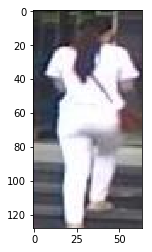

299


In [14]:
img = market_data_batch[0]

plt.imshow(deprocess_net_image(img))
plt.show()
print(market_label_batch[0])

In [15]:
print(market_labels[299])

575


In [16]:
untrained_market_net.blobs['data'].data[0, ...] = market_data_batch[0]
probs = untrained_market_net.forward()['probs'][0]
top_k = (-probs).argsort()[:5]
print '\n'.join('\t(%d) %5.2f%% %s' % (i+1, 100*probs[p], market_labels[p])
                for i, p in enumerate(top_k))

	(1)  0.13% 2
	(2)  0.13% 947
	(3)  0.13% 948
	(4)  0.13% 952
	(5)  0.13% 953


In [17]:
untrained_market_net.blobs['data'].data[0].shape

(3, 128, 64)

In [18]:
untrained_market_net.params['fc6_mar'][0].data

array([[ 0.01252119, -0.01341372,  0.00380788, ..., -0.00461669,
         0.00755223,  0.00075058],
       [-0.00322664, -0.00268002, -0.00364647, ...,  0.0016112 ,
        -0.00292274, -0.00455095],
       [-0.0040849 ,  0.00172594,  0.00747373, ..., -0.00535342,
        -0.01368337, -0.00850896],
       ..., 
       [ 0.00120365, -0.00498775, -0.00397475, ...,  0.00189395,
         0.0161881 ,  0.00148837],
       [ 0.00744416, -0.00385249, -0.0033659 , ..., -0.00408615,
         0.00667239, -0.00421648],
       [-0.00040665,  0.00444127,  0.00520884, ...,  0.01492967,
         0.00032097, -0.00051094]], dtype=float32)

### Train Network

In [27]:
from caffe.proto import caffe_pb2

def solver(train_net_path, test_net_path=None, base_lr=0.001):
    s = caffe_pb2.SolverParameter()

    # Specify locations of the train and (maybe) test networks.
    s.train_net = train_net_path
    if test_net_path is not None:
        s.test_net.append(test_net_path)
        s.test_interval = 1000  # Test after every 1000 training iterations.
        s.test_iter.append(100) # Test on 100 batches each time we test.

    # The number of iterations over which to average the gradient.
    # Effectively boosts the training batch size by the given factor, without
    # affecting memory utilization.
    s.iter_size = 1
    
    s.max_iter = 100000     # # of times to update the net (training iterations)
    
    # Solve using the stochastic gradient descent (SGD) algorithm.
    # Other choices include 'Adam' and 'RMSProp'.
    s.type = 'SGD'

    # Set the initial learning rate for SGD.
    s.base_lr = base_lr

    # Set `lr_policy` to define how the learning rate changes during training.
    # Here, we 'step' the learning rate by multiplying it by a factor `gamma`
    # every `stepsize` iterations.
    s.lr_policy = 'step'
    s.gamma = 0.1
    s.stepsize = 20000

    # Set other SGD hyperparameters. Setting a non-zero `momentum` takes a
    # weighted average of the current gradient and previous gradients to make
    # learning more stable. L2 weight decay regularizes learning, to help prevent
    # the model from overfitting.
    s.momentum = 0.9
    s.weight_decay = 5e-4

    # Display the current training loss and accuracy every 1000 iterations.
    s.display = 1000

    # Snapshots are files used to store networks we've trained.  Here, we'll
    # snapshot every 10K iterations -- ten times during training.
    s.snapshot = 10000
    s.snapshot_prefix = CAFFE_ROOT + 'models/market-1501/'
    
    # Train on the GPU.  Using the CPU to train large networks is very slow.
    s.solver_mode = caffe_pb2.SolverParameter.GPU
    
    # Write the solver to a temporary file and return its filename.
    with tempfile.NamedTemporaryFile(delete=False) as f:
        f.write(str(s))
        return f.name

In [28]:
def run_solvers(niter, solvers, disp_interval=10):
    """Run solvers for niter iterations,
       returning the loss and accuracy recorded each iteration.
       `solvers` is a list of (name, solver) tuples."""
    blobs = ('loss', 'acc')
    loss, acc = ({name: np.zeros(niter) for name, _ in solvers}
                 for _ in blobs)
    for it in range(niter):
        for name, s in solvers:
            s.step(1)  # run a single SGD step in Caffe
            loss[name][it], acc[name][it] = (s.net.blobs[b].data.copy()
                                             for b in blobs)
        if it % disp_interval == 0 or it + 1 == niter:
            loss_disp = '; '.join('%s: loss=%.3f, acc=%2d%%' %
                                  (n, loss[n][it], np.round(100*acc[n][it]))
                                  for n, _ in solvers)
            print '%3d) %s' % (it, loss_disp)     
    # Save the learned weights from both nets.
    weight_dir = tempfile.mkdtemp()
    weights = {}
    for name, s in solvers:
        filename = 'weights.%s.caffemodel' % name
        weights[name] = os.path.join(weight_dir, filename)
        s.net.save(weights[name])
    return loss, acc, weights

In [29]:
caffe.set_mode_gpu()

In [30]:
market_solver_filename = solver(market_net(train=True)[0], base_lr=1)

In [31]:
market_solver = caffe.get_solver(market_solver_filename)
market_solver.net.copy_from(ref_weights)

In [32]:
!cat $market_solver_filename

train_net: "/tmp/tmpDigi54"
base_lr: 1.0
display: 1000
max_iter: 100000
lr_policy: "step"
gamma: 0.10000000149
momentum: 0.899999976158
weight_decay: 0.000500000023749
stepsize: 20000
snapshot: 10000
snapshot_prefix: "/home/albert/caffe/models/market-1501/"
solver_mode: GPU
iter_size: 1
type: "SGD"


In [33]:
niter = 100000

print 'Running solvers for %d iterations...' % niter
solvers = [('pretrained', market_solver)]
loss, acc, weights = run_solvers(niter, solvers, disp_interval=1000)
print 'Done.'

train_loss = loss['pretrained']
train_acc = acc['pretrained']
market_weights = weights['pretrained']

Running solvers for 100000 iterations...
  0) pretrained: loss=6.621, acc= 0%
1000) pretrained: loss=6.601, acc= 2%
2000) pretrained: loss=6.481, acc= 0%
3000) pretrained: loss=6.449, acc= 0%
4000) pretrained: loss=6.431, acc= 0%
5000) pretrained: loss=6.353, acc= 2%
6000) pretrained: loss=6.568, acc= 0%
7000) pretrained: loss=6.442, acc= 4%
8000) pretrained: loss=6.367, acc= 0%
9000) pretrained: loss=6.339, acc= 0%
10000) pretrained: loss=6.223, acc= 2%
11000) pretrained: loss=6.351, acc= 0%
12000) pretrained: loss=6.317, acc= 2%
13000) pretrained: loss=6.406, acc= 0%
14000) pretrained: loss=6.465, acc= 0%
15000) pretrained: loss=6.355, acc= 2%
16000) pretrained: loss=6.383, acc= 2%
17000) pretrained: loss=6.413, acc= 2%
18000) pretrained: loss=6.283, acc= 2%
19000) pretrained: loss=6.405, acc= 0%
20000) pretrained: loss=6.425, acc= 0%
21000) pretrained: loss=6.188, acc= 6%
22000) pretrained: loss=6.046, acc= 2%
23000) pretrained: loss=6.310, acc= 0%
24000) pretrained: loss=6.208, acc

KeyboardInterrupt: 

In [34]:
market_solver.net.forward()

{'acc': array(0.019999999552965164, dtype=float32),
 'loss': array(6.149422645568848, dtype=float32)}

In [ ]:
def vis_square(data, cmap=None):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data, cmap=cmap); plt.axis('off')

In [ ]:
filters = market_solver.net.params['conv1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

In [ ]:
plt.figure(figsize=(10,10))
feat = market_solver.net.blobs['conv5'].data[0]
vis_square(feat, cmap=plt.cm.gray)

In [ ]:
plt.cm.